In [1]:
in_file =r'../../data/clean/articles.csv' 

import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df=pd.read_csv(in_file,index_col=False)
df.CR.fillna('',inplace=True)
df_ref=df.CR
refs_dict={}
i=0
for ref in df_ref:
    refs_dict[i]=[ref for ref in ref.split('; ')]
    i=i+1

In [3]:
refs_basket_dict={}
sources=[
    'MIS QUART',
    'J MANAGE INFORM SYST',
    'INFORM SYST RES'
]
sources=[', '+source+',' for source in sources]

for i in refs_dict:
    refs=refs_dict[i]
    refs_basket=[]
    for ref in refs:
        if any (source in ref for source in sources):
            refs_basket.append(ref)
    refs_basket_dict[i]=refs_basket

In [4]:
df['author']=df.AU.apply(lambda x: x.split(';')[0].replace(',',''))
df['signiture']=df.author+', '+df.PY.astype(str)+', '+df.J9+', V'+df.VL.astype(str)+', P'+df.BP.astype(str)
df['signiture']=df.apply(lambda x : x.signiture if pd.isnull(x.DI) else x.signiture+', DOI '+x.DI, axis=1 )

In [5]:
cite = open('..\csv\cite_basket.csv', 'w')
cite.write('citing,cited\n')

for row in refs_basket_dict:
    for ref in refs_basket_dict[row]:
        if ref in df.signiture.values:
            cite.write(str(row)+','+str(np.where(df.signiture==ref)[0][0])+'\n')
cite.close()

In [6]:
df=pd.read_csv('..\csv\cite_basket.csv',dtype=int)

In [7]:
max=np.max([df.citing.max(),df.cited.max()])
mm=np.zeros((max+1,max+1))
for row in df.iterrows():
    mm[row[1][0],row[1][1]]=1
#coc=np.tril(np.dot(mm.transpose(),mm),-1)

In [8]:
coc=np.zeros((max+1,max+1))
for row in range(max+1):
    for col in range(row+1, max+1):
        a=mm[:][row].sum()
        b=mm[:][col].sum()
        ab=np.dot(mm[:][row].transpose(),mm[:][col])
        if ab>2:
            coc[row][col]=ab/(min(a,b)*np.mean([a,b]))

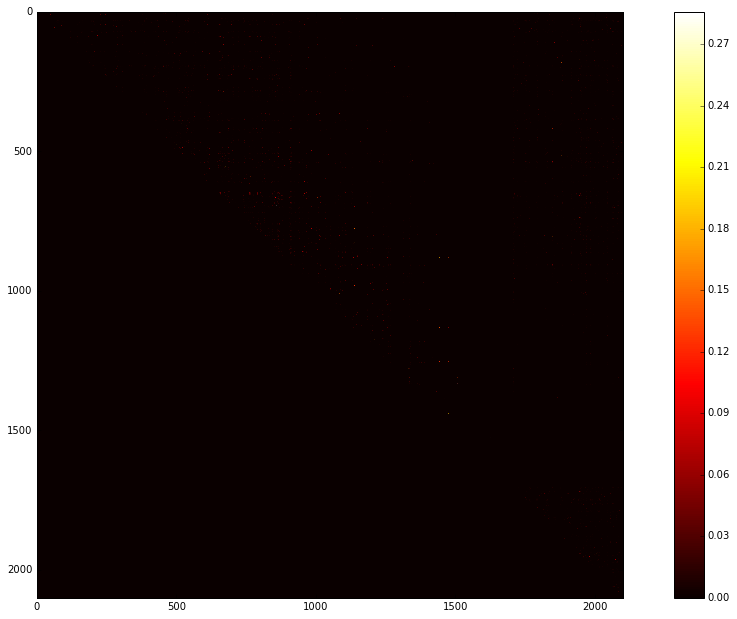

In [9]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.imshow(coc, cmap=plt.cm.hot)
plt.colorbar()
plt.show()

In [10]:
cocite = open('../csv/cocite.csv', 'w')
cocite.write('source,target,weight,type\n')

for row in range(coc.shape[0]):
    for col in range(row,coc.shape[1]):
        if coc[row][col] > 0:
            cocite.write(str(row)+','+str(col)+','+str(coc[row][col])+',undirected\n')
cocite.close()

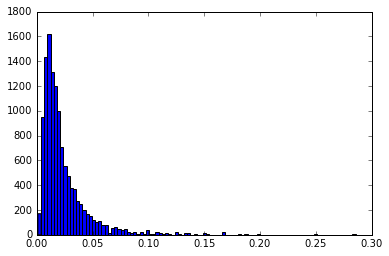

In [11]:
coc_df=pd.read_csv('../csv/cocite.csv')
l=coc_df.weight
hist=plt.hist(l,100)

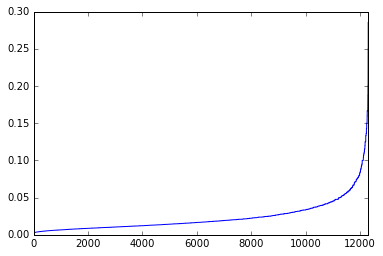

In [12]:
l=l.sort_values()
l=l.reset_index(drop=True)
l.plot(drawstyle='steps')

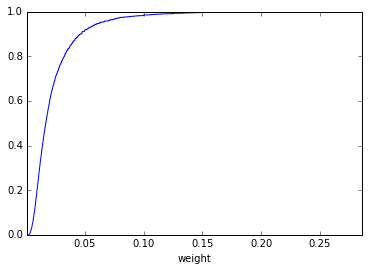

In [13]:
cum_dist = np.linspace(0.,1.,len(l))
cdf = pd.Series(cum_dist, index=l)
cdf.plot()

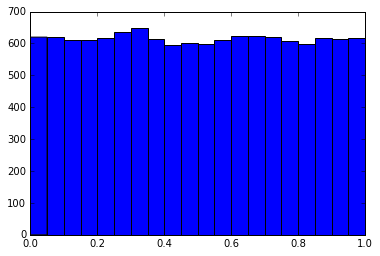

In [14]:
dic=cdf.to_dict()
coc_df['p']=coc_df.weight.apply(lambda x :1- dic[x])
p=coc_df.p
binwidth=.01
hist=plt.hist(p,20)

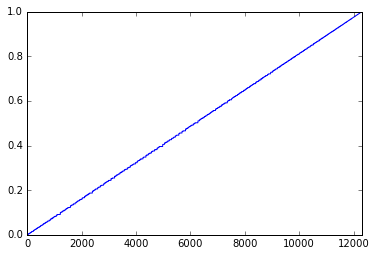

In [15]:
p=coc_df.p
p=p.sort_values()
p=p.reset_index(drop=True)
p.plot(drawstyle='steps')

In [16]:
coc_df.shape

(12308, 5)

In [17]:
coc_df['old_weight']=coc_df.weight
coc_df.drop('weight',inplace=True,axis=1)
coc_df['weight']=1-coc_df.p
coc_df['weight']=coc_df.weight**(1/coc_df.weight)
coc_df[['source','target','weight','type']].to_csv('..\csv\p_coc.csv',index=False)
coc_df.shape

(12308, 6)